# Decoding GLADS tiles

This notebook shows how to decode individual tiles of the GLADS dataset into a list of lat,lon,and date of alerts.

In [1]:
import requests
import math
import maya
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
tile_url='http://wri-tiles.s3.amazonaws.com/glad_prod/tiles/12/1376/2156.png'
im_arrays = misc.imread(requests.get(tile_url, stream=True).raw, mode='RGBA')

/Users/Ben/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


### Example of tile contents

Breaking down the tile contents, we can see what the typical bands of a png tile look like.
The bands are R,G,B,A, where the R (red) and G (green) bands together encode the days since 01-01-2015.
The days are counted in a base 255 number system, where the G channel counts days, until it reaches 255,
and then at each 255 it increments the value of the corresponding R pixel by 1, and resets to 0 in the Green channel. Thus the date of an alert is 01-01-2015 incremented by the number of days given by the value in the R channel * 255 added to the value of the G channel.

The blue channel holds the confidence interval, where 0 indcates no alert, 155 indicates an unconfident altert, and 255 indicates a confident alert.

The Alpha channel has transparency only can be ignored.

BAND 0: max=4, min=0


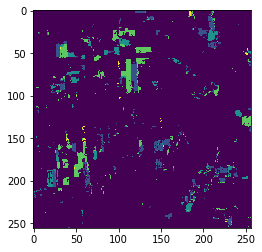

BAND 1: max=249, min=0


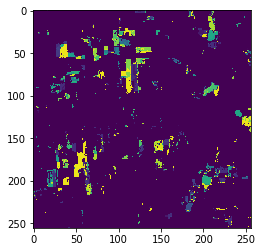

BAND 2: max=255, min=0


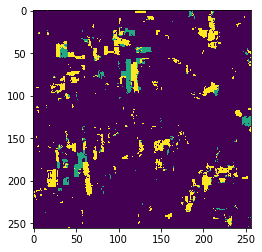

BAND 3: max=255, min=255


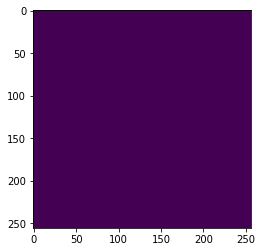

In [3]:
for band in range(0,4):
    print(f"BAND {band}: max={im_arrays[:,:,band].max()}, min={im_arrays[:,:,band].min()}")
    plt.imshow(im_arrays[:,:,band])
    plt.show()

## Extract info from the URL

We extract the Z,X,Y data from the URL, as follows and use it to calculate the metadata of the tile

In [4]:
def xyz_from_url(url):
    """Parse the url to  X, Y, Z"""
    z,x,y = tile_url.split('/')[-3:]
    y = y.split('.png')[0]
    z = int(z)
    y = int(y)
    x = int(x)
    return  x, y, z


def num2deg(xtile, ytile, zoom):
    """From a given Z,X,Y we can identify the upper left corner lat long"""
    n = 2.0 ** zoom
    lon_deg = xtile / n * 360.0 - 180.0
    lat_rad = math.atan(math.sinh(math.pi * (1 - 2 * ytile / n)))
    lat_deg = math.degrees(lat_rad)
    return lat_deg, lon_deg

In [5]:
x,y,z = xyz_from_url(tile_url)
print(f'x={x}, y={y}, z={z}')

ul_corner_lat, ul_corner_lon = num2deg(x,y,z)
print(f"Upper Left-hand corner Latitude = {ul_corner_lat}, \nUpper Left-hand corner Longitude = {ul_corner_lon}")

x=1376, y=2156, z=12
Upper Left-hand corner Latitude = -9.449061826881424, 
Upper Left-hand corner Longitude = -59.0625


## Convert pixel values and indexes into dates and lat, lon co-ordinates

Find all xy,y locations of pixels within a certain date range, and where the confidence is high, and convert these into a list of decimal latitudes, longitudes (relating to the upper-left conrner of the pixels), and the calander dates of the alerts (YYYY-MM-DD).

In [6]:
def gen_date_array(im_arrays, confident_values=True, verbose=False):
    """Recieve array (256,256,4) of R,G,B,A. Extract the date which has been encoded in the R +G
    bands. Date is days since 01-01-2015, where integer day is in the G-band, in base 256, once
    255 is reached, the corresponding array element in the R-band is incremented.
    Should return a numpy array of strings with either None, or a string date (YYYY-MM-DD).
    The dates are only returned if the blue-band has a value of 255, indicating a valid pixel.
    E.g. R=1, G=1 should equal 256 days since 01-01-2015
         R=0, G=10 should equal 10 days since 01-01-2015
    """
    base_date = maya.parse('01-01-2015')
    tmp = []
    red = im_arrays[:,:,0]
    green = im_arrays[:,:,1]
    
    if confident_values:
        blue = im_arrays[:,:,2]
        mask = blue != 255
        red = np.ma.masked_array(red, mask=mask)
        green = np.ma.masked_array(green, mask=mask)
    rg_flat = [pair for pair in zip(red.flatten(), green.flatten())]
    for r_band, g_band in rg_flat:
        if(np.sum([r_band, g_band]) > 0):
            days_to_add = (r_band * 255) + g_band
            final_date = base_date.add(days=int(days_to_add)).datetime().date()
            if verbose:
                print(f'r={r_band}, g={g_band}: {r_band * 255} + {g_band} = {days_to_add} , date = {final_date}')
            tmp.append(str(final_date))
        else:
            tmp.append(None)
    tmp = np.array(tmp).reshape((256,256))
    return tmp


def date_array_to_xydate_list(date_array):
    """Get a list of the x, y index for every element in the date array that is not None
    iterate over it and create a list of all the x,y, date-string values"""
    xydate = []
    idx = date_array.nonzero()
    xydate = [ [x,y,date_array[x,y]] for x,y in zip(idx[0], idx[1])]
    return xydate


def return_latlongdate(alerts_array, tilelon, tilelat,  tilezoom):
    """Convert a list of x,y, dates from date_array_to_xydate_list to a list of
    lat, lon, date (where lon, lat are the upper-left corner of the pixel).
    Pixel size in decimal degress is given by distance variable in this function.
    This works via trigonmetry!
    """
    distance = math.fabs((360/256)*(math.cos(tilelat)/(2**tilezoom)))
    return [[(tilelat - alert[0]*distance) , (alert[1]*distance + tilelon ), alert[2]] for alert in alerts_array]
        

In [7]:
# Get the tile metadata
x,y,z = xyz_from_url(tile_url)
ul_corner_lat, ul_corner_lon = num2deg(x,y,z)

# Scrape a list of x,y, dates from the tile (where alert confidence is high)
date_array = gen_date_array(im_arrays, confident_values=True)
good_list = date_array_to_xydate_list(date_array)

# convert the xydate to lon,lat,time
output_list = return_latlongdate(good_list, ul_corner_lon, ul_corner_lat, z)

output_list[0:100]

/Users/Ben/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: UserWarning: Warning: converting a masked element to nan.
  return umr_sum(a, axis, dtype, out, keepdims)


[[-9.449061826881424, -59.05700845553423, '2015-10-16'],
 [-9.449061826881424, -59.05666523400512, '2015-10-16'],
 [-9.449061826881424, -59.020626973448515, '2015-10-16'],
 [-9.449061826881424, -59.02028375191941, '2015-09-30'],
 [-9.449061826881424, -59.01994053039029, '2015-09-30'],
 [-9.449061826881424, -59.01959730886119, '2015-09-30'],
 [-9.449061826881424, -59.01925408733207, '2015-09-30'],
 [-9.449061826881424, -59.018910865802965, '2015-09-30'],
 [-9.449061826881424, -59.01856764427385, '2015-09-30'],
 [-9.449061826881424, -59.018224422744744, '2015-09-30'],
 [-9.449061826881424, -59.01788120121563, '2015-10-16'],
 [-9.449061826881424, -59.01753797968652, '2015-10-16'],
 [-9.449061826881424, -59.01719475815741, '2016-11-03'],
 [-9.449405048410535, -59.021313416506736, '2015-10-24'],
 [-9.449405048410535, -59.02097019497763, '2015-10-16'],
 [-9.449405048410535, -59.020626973448515, '2015-10-16'],
 [-9.449405048410535, -59.02028375191941, '2015-09-30'],
 [-9.449405048410535, -59.

In [8]:
# If you want to write these data out to a text file as a list

with open("./output.txt",'w') as f:
    for line in output_list:
        a,b,c = line
        f.write(f"{a}, {b}, {c}\n")

### Test a specific Glads issue

Possible bug in GLADS noted in [BC thread](https://basecamp.com/3063126/projects/10728552/todos/327859724#comment_568350645). We need to grab that tile and look to see where the bug comes from. Seems like data are being flagged as being within 7 days of max date when this is likely erroneous.

In [9]:
def deg2num(lat_deg, lon_deg, zoom):
    """Based on a zoom and lat long, get tile numbers"""
    lat_rad = math.radians(lat_deg)
    n = 2.0 ** zoom
    xtile = int((lon_deg + 180.0) / 360.0 * n)
    ytile = int((1.0 - math.log(math.tan(lat_rad) + (1 / math.cos(lat_rad))) / math.pi) / 2.0 * n)
    return (xtile, ytile)

In [10]:
# Use the tile numbers and zoom to get the desired tile

deg2num(zoom=9, lat_deg=0.98, lon_deg =15.79)

(278, 254)

In [11]:
tile_url='http://wri-tiles.s3.amazonaws.com/glad_prod/tiles/9/278/254.png'
im_arrays = misc.imread(requests.get(tile_url, stream=True).raw, mode='RGBA')

/Users/Ben/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


BAND 0: max=4, min=0


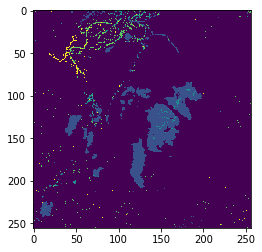

BAND 1: max=247, min=0


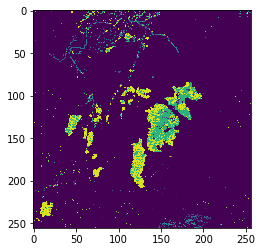

BAND 2: max=253, min=0


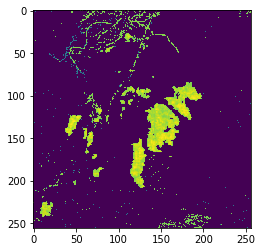

BAND 3: max=255, min=255


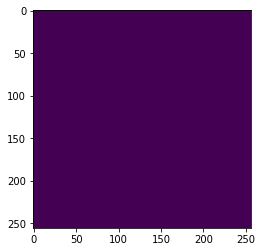

In [12]:
for band in range(0,4):
    print(f"BAND {band}: max={im_arrays[:,:,band].max()}, min={im_arrays[:,:,band].min()}")
    plt.imshow(im_arrays[:,:,band])
    plt.show()

In [13]:
# Get the tile metadata
x,y,z = xyz_from_url(tile_url)
ul_corner_lat, ul_corner_lon = num2deg(x,y,z)

# Scrape a list of x,y, dates from the tile (where alert confidence is high)
date_array = gen_date_array(im_arrays, confident_values=True)
good_list = date_array_to_xydate_list(date_array)

# convert the xydate to lon,lat,time
output_list = return_latlongdate(good_list, ul_corner_lon, ul_corner_lat, z)

output_list[0:10]

/Users/Ben/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: UserWarning: Warning: converting a masked element to nan.
  return umr_sum(a, axis, dtype, out, keepdims)


[]